# TAOR project: Managing solid waste in Central Portugal

## Setup

In the cell below we will load the core libraries we will be using.

In [1]:
# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas as gp
from shapely.geometry import Point, Polygon, LineString

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# Pyomo
from pyomo.environ import *

# Misc libraries
import os

# Scripting library
import get_basura as gb

## Optimization models

The models are instantiated as Pyomo objects and are solved using the NEOS server. 

### Modified model from Antunes et al (2001)

A minor change is proposed in the objective function from Antunes et al (2001) where the $m$ term is not considered and a constraint is imposed on the maximum number of new transfer stations to be built in the network. This change does not alter the optimal locations of the incinerator nor the transfer stations; however, this modification enforces only cost terms in the objective function.

This model is solved using CPLEX.

In [2]:
# Max distances
demax = 25
dlmax = 125

# Bring the data as dictionaries
q_j, dist_jk_dist_jl, dist_kl, w_jk0, f_jk_f_jl, g_kl = gb.get_data(demax, dlmax)

# Parameters
c_c = 0.045
c_u = 0.128571

q = sum(q_j.values())

# s_k = 204400 # original value from Dr Antunes
s_k = 182500 # 500 ton/day capacity

m = 1E6

# Step 0: Instantiate a model object
model = ConcreteModel()
model.dual = Suffix(direction=Suffix.IMPORT)

# Step 1: Define index sets
J = list(q_j.keys())
K = list(q_j.keys())
L = list(q_j.keys())
J1 = ["Arouca", "Estarreja", "Oliveira de Azemeis", "Sao Joao da Madeira", "Sever do Vouga", "Gois", "Lousa", "Pampilhosa da Serra", "Penela", "Vila Nova Poiares", "Ansiao", "Castanheira de Pera", "Pedrogao Grande"]
K1 = ["Estarreja", "Oliveira de Azemeis", "Sever do Vouga", "Gois", "Pampilhosa da Serra", "Ansiao"]

# Step 2: Define the decision variables
model.w_jk = Var(J, K, within= Binary)
model.v_jl = Var(J, L, within=Binary)
model.y_k = Var(K, within=Binary)
model.z_l = Var(L, within=Binary)
model.x_kl = Var(K,L, domain = NonNegativeReals)

# Step 3: Objective function
def obj_rule(model):
    return sum( c_u * dist_jk_dist_jl[j,k] * q_j[j] * model.w_jk[j,k] for j in J for k in K)+\
        sum( c_u * dist_jk_dist_jl[j,l] * q_j[j] * model.v_jl[j,l] for j in J for l in L)+\
        sum( c_c * dist_kl[k,l] * model.x_kl[k,l] for k in K for l in L) #+ sum( m*model.y_k[k] for k in K)

model.Cost = Objective(rule=obj_rule, sense = minimize)

# Step 4: Constraints              
def rule_1(model,J):
    return sum( model.w_jk[J,k] for k in K ) + \
           sum( model.v_jl[J,l] for l in L ) == 1 
    
def rule_2(model,K):
    return sum( q_j[j]*model.w_jk[j, K] for j in J ) == sum( model.x_kl[K,l] for l in L )  
    
def rule_3(model,J,K):
    return model.w_jk[J,K] <= f_jk_f_jl[J,K]*model.y_k[K]

def rule_4(model,J,L):
    return model.v_jl[J,L] <= f_jk_f_jl[J,L]*model.z_l[L]
   
def rule_5(model,K,L):
    return model.x_kl[K,L] <= g_kl[K,L]*q*model.z_l[L]

def rule_6(model,K):
    return sum(q_j[j]*model.w_jk[j,K] for j in J)<=s_k*model.y_k[K]

def rule_7(model):
    return sum(model.z_l[l] for l in L)==1

def rule_8(model, J1, K1):
    return model.w_jk[J1,K1] == w_jk0[J1, K1]

def rule_9(model): #experiment, incinerator not in Agueda
    return (model.z_l["Agueda"] == 0)

def rule_10(model): #experiment, incinerator not in Mealheada
    return (model.z_l["Mealhada"] == 0)

def rule_11(model): #experiment, incinerator not in Anadia
    return (model.z_l["Anadia"] == 0)

def rule_12(model, J1, K1):
    return model.y_k[K1] >= w_jk0[J1, K1]

def rule_13(model):
    return sum(model.y_k[k] for k in K) <= 9

def rule_14(model, J):
    return sum(model.w_jk[J, k] for k in K) <= 9

model.C_1 = Constraint( J, rule=rule_1 )
model.C_2 = Constraint( K, rule=rule_2 )
model.C_3 = Constraint( J, K, rule=rule_3 )
model.C_4 = Constraint( J, L, rule=rule_4 )
model.C_5 = Constraint( K, L, rule = rule_5)
model.C_6 = Constraint( K, rule = rule_6 )
model.C_7 = Constraint( rule = rule_7)
model.C_8 = Constraint(J1, K1, rule = rule_8) 
#model.C_9 = Constraint( rule = rule_9) # experiment, incinerator not in Agueda
#model.C_10 = Constraint( rule = rule_10) # experiment, incinerator not in Mealhada
#model.C_11 = Constraint( rule = rule_11) # experiment, incinerator not in Anadia
#model.c_12 = Constraint( J1, K1, rule = rule_12) # allow the municipalities to go to other ts
model.c_13 = Constraint( rule = rule_13) # limit number of transfer stations without using the m term
#model.c_14 = Constraint( J, rule = rule_14) # limit number of municipalities assigned to a ts

# Call Mosel and solve
#results = SolverFactory('amplxpress').solve(model)

# Call the NEOS server and use CPLEX for solving

# email address
os.environ['NEOS_EMAIL'] = 's2123659@ed.ac.uk'

solver_manager = SolverManagerFactory('neos')
results = solver_manager.solve(model, opt="cplex")

results.write()


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 4076
  Number of variables: 3960
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: CPLEX 20.1.0.0\x3a optimal integer solution; objective 1327415.8206406198; 448 MIP simplex iterations; 0 branch-and-bound nodes; absmipgap = 2.32831e-10, relmipgap = 1.75401e-16
  Termination condition: optimal
  Id: 2
# ----------------------------------------------------------
#   Solution Information
# ------------------------------------

### Results

In [24]:
# Output detailed solution
header = "Optimal solution"
print(f"\n{header}")
print(f"="*len(header))

if 'ok' == str(results.Solver.status):
    print(f"Optimal value = € {model.Cost():.2f}")
    #t_cost = model.Cost() - m*sum(model.y_k[k]() for k in K)
    #print(f"Transportation costs = €{t_cost:.2f}")

    print("\nTransfer stations:")
    for k in K:
        if(model.y_k[k]() == 1):
            print(k, model.y_k[k]())
    
    print("\nIncinerator:")
    for l in L:
        if(model.z_l[l]() == 1):
            print(l, model.z_l[l]())
else:
    print("No Valid Solution Found")


Optimal solution
Optimal value = € 1327415.82

Transfer stations:
Estarreja 1.0
Ilhavo 1.0
Oliveira de Azemeis 1.0
Sever do Vouga 1.0
Coimbra 1.0
Gois 1.0
Montemor-o-Velho 1.0
Pampilhosa da Serra 1.0
Ansiao 1.0

Incinerator:
Agueda 1.0


### Visualization

Here are some auxiliary lists that will be used for displaying the maps

In [4]:
# Fill lists with the optimization results 

# Transfer stations
y = []

for k in K:
    if(model.y_k[k]() == 1):
        y.append(k)

#Incinerator
z = []

for l in L:
    if(model.z_l[l]() == 1):
        z.append(l)

# Link between municipalities and transfer stations
links_ts = []

for k in K:
    for j in J:
        if(model.w_jk[j, k]() == 1):
            links_ts.append((k, j))

# Link between municipalities and the incinerator
links_inc = []

for l in L:
    for j in J:
        if(model.v_jl[j, l]() == 1):
            links_inc.append((l, j))

# Get the coordinates
ts_new, ts_exist, inc, mun, w_jk, v_jl = gb.get_coord(y, z, links_ts, links_inc, K1)

#### GIS

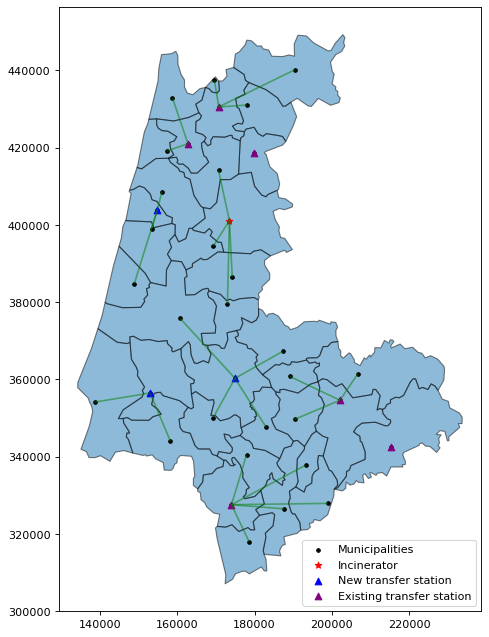

In [5]:
gis_map = gb.create_gis(ts_new, ts_exist, inc, w_jk, v_jl)
gis_map

#### Folium map

In [6]:
# Create map instance and display

centro_map = gb.create_folium_map(ts_new, ts_exist, inc, mun, w_jk, v_jl)
centro_map

## Modified model
This model considers the addition of recycling centers in the network

In [7]:
# Max distances
demax = 25
dlmax = 125

# Bring the data as dictionaries
q_j, dist_jk_dist_jl, dist_kl, w_jk0, f_jk_f_jl, g_kl = gb.get_new_data(demax, dlmax, year = "2015")

# Parameters
c_c = 0.045
c_u = 0.128571

q = sum(q_j.values())

# s_k = 204400 # original value from Dr Antunes
s_k = 182500 # 500 ton/day capacity

m = 1E6

# Step 0: Instantiate a model object
model_rob = ConcreteModel()
model_rob.dual = Suffix(direction=Suffix.IMPORT)

# Step 1: Define index sets
J = list(q_j.keys())
K = list(q_j.keys())
L = list(q_j.keys())
J1 = ["Arouca", "Estarreja", "Oliveira de Azemeis", "Sao Joao da Madeira", "Sever do Vouga", "Gois", "Lousa", "Pampilhosa da Serra", "Penela", "Vila Nova Poiares", "Ansiao", "Castanheira de Pera", "Pedrogao Grande"]
K1 = ["Estarreja", "Oliveira de Azemeis", "Sever do Vouga", "Gois", "Pampilhosa da Serra", "Ansiao"]

# Step 2: Define the decision variables
model_rob.w_jk = Var(J, K, within= Binary)
model_rob.v_jl = Var(J, L, within=Binary)
model_rob.y_k = Var(K, within=Binary)
model_rob.z_l = Var(L, within=Binary)
model_rob.x_kl = Var(K,L, domain = NonNegativeReals)

# Step 3: Objective function
def obj_rule(model_rob):
    return sum( c_u * dist_jk_dist_jl[j,k] * q_j[j] * model_rob.w_jk[j,k] for j in J for k in K)+\
        sum( c_u * dist_jk_dist_jl[j,l] * q_j[j] * model_rob.v_jl[j,l] for j in J for l in L)+\
        sum( c_c * dist_kl[k,l] * model_rob.x_kl[k,l] for k in K for l in L) #+ sum( m*model.y_k[k] for k in K)

model_rob.Cost = Objective(rule=obj_rule, sense = minimize)

# Step 4: Constraints              
def rule_1(model_rob,J):
    return sum( model_rob.w_jk[J,k] for k in K ) + \
           sum( model_rob.v_jl[J,l] for l in L ) == 1 
    
def rule_2(model_rob,K):
    return sum( q_j[j]*model_rob.w_jk[j, K] for j in J ) == sum( model_rob.x_kl[K,l] for l in L )  
    
def rule_3(model_rob,J,K):
    return model_rob.w_jk[J,K] <= f_jk_f_jl[J,K]*model_rob.y_k[K]

def rule_4(model_rob,J,L):
    return model_rob.v_jl[J,L] <= f_jk_f_jl[J,L]*model_rob.z_l[L]
   
def rule_5(model_rob,K,L):
    return model_rob.x_kl[K,L] <= g_kl[K,L]*q*model_rob.z_l[L]

def rule_6(model_rob,K):
    return sum(q_j[j]*model_rob.w_jk[j,K] for j in J)<=s_k*model_rob.y_k[K]

def rule_7(model_rob):
    return sum(model_rob.z_l[l] for l in L)==1

def rule_8(model_rob, J1, K1):
    return model_rob.w_jk[J1,K1] == w_jk0[J1, K1]

def rule_9(model_rob): #experiment, incinerator not in Agueda
    return (model.z_l["Agueda"] == 0)

def rule_10(model_rob): #experiment, incinerator not in Mealheada
    return (model_rob.z_l["Mealhada"] == 0)

def rule_11(model_rob): #experiment, incinerator not in Anadia
    return (model_rob.z_l["Anadia"] == 0)

def rule_12(model_rob, J1, K1):
    return model_rob.y_k[K1] >= w_jk0[J1, K1]

def rule_13(model_rob):
    return sum(model_rob.y_k[k] for k in K) <= 9

def rule_14(model_rob, J):
    return sum(model_rob.w_jk[J, k] for k in K) <= 9

model_rob.C_1 = Constraint( J, rule=rule_1 )
model_rob.C_2 = Constraint( K, rule=rule_2 )
model_rob.C_3 = Constraint( J, K, rule=rule_3 )
model_rob.C_4 = Constraint( J, L, rule=rule_4 )
model_rob.C_5 = Constraint( K, L, rule = rule_5)
model_rob.C_6 = Constraint( K, rule = rule_6 )
model_rob.C_7 = Constraint( rule = rule_7)
model_rob.C_8 = Constraint(J1, K1, rule = rule_8) 
#model_rob.C_9 = Constraint( rule = rule_9) # experiment, incinerator not in Agueda
#model_rob.C_10 = Constraint( rule = rule_10) # experiment, incinerator not in Mealhada
#model_rob.C_11 = Constraint( rule = rule_11) # experiment, incinerator not in Anadia
#model_rob.c_12 = Constraint( J1, K1, rule = rule_12) # allow the municipalities to go to other ts
model_rob.c_13 = Constraint( rule = rule_13) # limit number of transfer stations without using the m term
#model_rob.c_14 = Constraint( J, rule = rule_14) # limit number of municipalities assigned to a ts

# Call Mosel and solve
#results = SolverFactory('amplxpress').solve(model_rob)

# Call the NEOS server and use MOSEK for solving

# email address
os.environ['NEOS_EMAIL'] = 's2123659@ed.ac.uk'

solver_manager = SolverManagerFactory('neos')
results_rob = solver_manager.solve(model_rob, opt="cplex")

results_rob.write()


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 4076
  Number of variables: 3960
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: CPLEX 20.1.0.0\x3a optimal integer solution; objective 1054622.0474321428; 461 MIP simplex iterations; 0 branch-and-bound nodes
  Termination condition: optimal
  Id: 2
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solu

### Results

In [25]:
# Output detailed solution
header = "Optimal solution"
print(f"\n{header}")
print(f"="*len(header))

if 'ok' == str(results_rob.Solver.status):
    print(f"Optimal value = € {model_rob.Cost():.2f}")
    #t_cost_rob = model_rob.Cost() - m*sum(model_rob.y_k[k]() for k in K)
    #print(f"Transportation costs = €{t_cost_rob:.2f}")

    print("\nTransfer stations:")
    for k in K:
        if(model_rob.y_k[k]() == 1):
            print(k, model_rob.y_k[k]())
    
    print("\nIncinerator:")
    for l in L:
        if(model_rob.z_l[l]() == 1):
            print(l, model_rob.z_l[l]())
else:
    print("No Valid Solution Found")


Optimal solution
Optimal value = € 1054622.05

Transfer stations:
Estarreja 1.0
Ilhavo 1.0
Oliveira de Azemeis 1.0
Sever do Vouga 1.0
Coimbra 1.0
Gois 1.0
Montemor-o-Velho 1.0
Pampilhosa da Serra 1.0
Ansiao 1.0

Incinerator:
Mealhada 1.0


### Visualization

In [9]:
# Fill lists with the optimization results 

# Transfer stations
y = []

for k in K:
    if(model_rob.y_k[k]() == 1):
        y.append(k)

#Incinerator
z = []

for l in L:
    if(model_rob.z_l[l]() == 1):
        z.append(l)

# Link between municipalities and transfer stations
links_ts = []

for k in K:
    for j in J:
        if(model_rob.w_jk[j, k]() == 1):
            links_ts.append((k, j))

# Link between municipalities and the incinerator
links_inc = []

for l in L:
    for j in J:
        if(model_rob.v_jl[j, l]() == 1):
            links_inc.append((l, j))

# Get the coordinates
ts_new, ts_exist, inc, mun, w_jk, v_jl = gb.get_coord(y, z, links_ts, links_inc, K1)

#### GIS

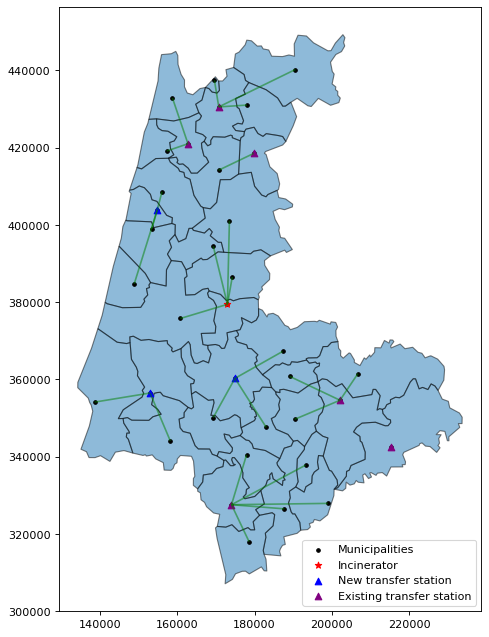

In [10]:
gis_map = gb.create_gis(ts_new, ts_exist, inc, w_jk, v_jl)
gis_map

#### Folium map

In [11]:
new_map = gb.create_folium_map(ts_new, ts_exist, inc, mun, w_jk, v_jl)
new_map